In [1]:
"""This implementation follows the Bayesian Recursive Update framework from:
Dr. Popov's paper"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
x, y = 0.0, 0.0
vx, vy = 1.0, 0.5
dt = 0.1
process_noise_std = 0.05

In [4]:
def simulate_true_trajectory(total_time=20, dt=0.1):
    steps = int(total_time / dt)
    x, y = 0.0, 0.0
    vx, vy = 1.0, 0.5
    acceleration_noise_std = 0.05

    data = []

    for step in range(steps):
        t = step * dt
        # Add noise to acceleration (changes in velocity)
        vx += np.random.normal(0, acceleration_noise_std) * dt
        vy += np.random.normal(0, acceleration_noise_std) * dt

        # Update position
        x += vx * dt
        y += vy * dt

        data.append([t, x, y, vx, vy])

    return pd.DataFrame(data, columns=["time", "x_true", "y_true", "vx_true", "vy_true"])
simulate_true_trajectory()

,time,x_true,y_true,vx_true,vy_true
0,0.0,0.100248,0.049931,1.002484,0.499309
1,0.1,0.200821,0.100623,1.005722,0.506924
2,0.2,0.301276,0.151199,1.004551,0.505753
3,0.3,0.402520,0.202158,1.012447,0.509590
4,0.4,0.503530,0.253388,1.010100,0.512303
...,...,...,...,...,...
195,19.5,19.036842,9.999671,1.016185,0.518985
196,19.6,19.137800,10.052485,1.009583,0.528142
197,19.7,19.239348,10.105065,1.015481,0.525797
198,19.8,19.340040,10.158321,1.006915,0.532566


In [5]:
def simulate_sensors(df, gps_freq=1, imu_freq=10, camera_freq=2):
    """
    Simulate sensor readings with different frequencies and noise characteristics.

    GPS: Position measurements (x, y) with Gaussian noise
    IMU: Velocity measurements (vx, vy) with Gaussian noise
    Camera: Position measurement (x) with Gaussian noise and bias
    """
    gps_noise_std = 0.3
    imu_noise_std = 0.1
    cam_noise_std = 0.5
    cam_bias = 0.2  # Constant bias in camera measurement

    # Calculate step intervals for each sensor based on frequency
    gps_interval = int(1 / (gps_freq * dt))
    imu_interval = int(1 / (imu_freq * dt))
    cam_interval = int(1 / (camera_freq * dt))

    # Initialize columns with NaN
    df["gps_x"] = np.nan
    df["gps_y"] = np.nan
    df["imu_vx"] = np.nan
    df["imu_vy"] = np.nan
    df["cam_x"] = np.nan

    # Add sensor readings at appropriate intervals
    for i in range(len(df)):
        if i % gps_interval == 0:
            df.loc[i, "gps_x"] = df.loc[i, "x_true"] + np.random.normal(0, gps_noise_std)
            df.loc[i, "gps_y"] = df.loc[i, "y_true"] + np.random.normal(0, gps_noise_std)

        if i % imu_interval == 0:
            df.loc[i, "imu_vx"] = df.loc[i, "vx_true"] + np.random.normal(0, imu_noise_std)
            df.loc[i, "imu_vy"] = df.loc[i, "vy_true"] + np.random.normal(0, imu_noise_std)

        if i % cam_interval == 0:
            # Camera has bias in addition to noise
            df.loc[i, "cam_x"] = df.loc[i, "x_true"] + cam_bias + np.random.normal(0, cam_noise_std)

    return df



In [6]:
def add_asynchrony(df, drop_prob=0.1):
    """
    Randomly drop sensor readings to simulate asynchronous and missing data.
    """
    for col in ["gps_x", "gps_y", "imu_vx", "imu_vy", "cam_x"]:
        mask = np.random.rand(len(df)) < drop_prob
        df.loc[mask, col] = np.nan
    return df




In [7]:

# Generate simulated data
dt = 0.1
df = simulate_true_trajectory(total_time=20, dt=dt)
df = simulate_sensors(df, gps_freq=1, imu_freq=10, camera_freq=2)
df = add_asynchrony(df, drop_prob=0.1)

In [8]:
def build_models(dt=0.1, state_dim=4):
    """
    Define system model and initial state for the filters.

    Returns:
    F: State transition matrix
    Q: Process noise covariance matrix
    s0: Initial state estimate
    P0: Initial state covariance
    """
    # State transition matrix (constant velocity model)
    F = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])

    # Process noise covariance (small noise in velocity)
    q_pos = 1e-4  # Small position noise
    q_vel = 1e-3  # Small velocity noise
    Q = np.diag([q_pos, q_pos, q_vel, q_vel])

    # Initial state and covariance
    s0 = np.array([0.0, 0.0, 1.0, 0.5])  # [x, y, vx, vy]
    P0 = np.diag([1.0, 1.0, 0.5, 0.5])   # Initial uncertainty

    return F, Q, s0, P0

def enkf_predict(ensemble, F, Q):
    """
    Prediction step for Ensemble Kalman Filter.

    Parameters:
    ensemble: Current ensemble of states (N x state_dim)
    F: State transition matrix
    Q: Process noise covariance matrix

    Returns:
    Updated ensemble after prediction step
    """
    N = ensemble.shape[0]

    # Apply state transition to each ensemble member
    ensemble = ensemble @ F.T

    # Add process noise
    noise = np.random.multivariate_normal(np.zeros(Q.shape[0]), Q, size=N)
    ensemble += noise

    return ensemble

In [15]:
def enkf_update(ensemble, z, H, R):
    """
    Standard Ensemble Kalman Filter update step.

    Parameters:
    ensemble: Current ensemble of states (N x state_dim)
    z: Measurement vector
    H: Measurement matrix
    R: Measurement noise covariance matrix

    Returns:
    Updated ensemble after assimilation
    """
    N, state_dim = ensemble.shape
    meas_dim = z.shape[0]

    # Ensemble mean and anomalies
    x_mean = np.mean(ensemble, axis=0)
    X_anom = ensemble - x_mean  # Anomalies (deviations from mean)

    # Project ensemble to measurement space
    Y_ens = ensemble @ H.T
    y_mean = np.mean(Y_ens, axis=0)
    Y_anom = Y_ens - y_mean

    # Compute Kalman gain
    P_xy = (X_anom.T @ Y_anom) / (N - 1)
    P_yy = (Y_anom.T @ Y_anom) / (N - 1) + R
    K = P_xy @ np.linalg.inv(P_yy)

    # Generate perturbed observations
    z_perturbed = z + np.random.multivariate_normal(np.zeros(meas_dim), R, size=N)

    # Update ensemble
    innovation = z_perturbed - Y_ens
    ensemble += innovation @ K.T

    return ensemble

def bruenkf_update(ensemble, z, H, R, m=2):
    """
    Bayesian Recursive Update for Ensemble Kalman Filter based on Algorithm 1 from:
    Popov & Sandu (2024). Bayesian Recursive Update for Ensemble Kalman Filters.

    Parameters:
    ensemble: Current ensemble of states (N x state_dim)
    z: Measurement vector
    H: Measurement matrix
    R: Measurement noise covariance matrix
    m: Number of recursive update steps

    Returns:
    Updated ensemble after multi-step assimilation
    """
    N = ensemble.shape[0]  #Number of ensemble members
    state_dim = ensemble.shape[1]  #State dimension

    for k in range(m):
        # Compute ensemble mean and covariance
        x_mean = np.mean(ensemble, axis=0)
        X_anom = ensemble - x_mean  # Anomalies
        P = (X_anom.T @ X_anom) / (N - 1)  # Ensemble covariance

        # Compute Kalman gain with inflated measurement noise
        HPH = H @ P @ H.T
        inv_term = np.linalg.inv(HPH + m * R)
        K = P @ H.T @ inv_term

        # Update each ensemble member
        innovation = z - ensemble @ H.T  # Innovation for each member
        update_term = innovation @ K.T  # Update term

        # Generate perturbations with covariance K (m R) K^T
        pert_cov = K @ (m * R) @ K.T
        perturbations = np.random.multivariate_normal(np.zeros(state_dim), pert_cov, size=N)

        # Apply update and perturbations
        ensemble = ensemble + update_term + perturbations

    return ensemble

In [16]:
# Initialize models
F, Q, s0, P0 = build_models(dt=dt)
state_dim = len(s0)

# Ensemble size
N = 100

# Initialize ensembles
ensemble_standard = np.random.multivariate_normal(s0, P0, size=N)
ensemble_bru = np.random.multivariate_normal(s0, P0, size=N)

# Number of recursive updates for BRUEnKF
m_recursive = 3

# Measurement noise covariances
R_gps = np.diag([0.3**2, 0.3**2])       # GPS noise
R_imu = np.diag([0.1**2, 0.1**2])       # IMU noise
R_cam = np.array([[0.5**2]])            # Camera noise

# Measurement matrices
H_gps = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])  # Measures x, y
H_imu = np.array([[0, 0, 1, 0], [0, 0, 0, 1]])  # Measures vx, vy
H_cam = np.array([[1, 0, 0, 0]])                # Measures x only

# Storage for results
estimates_standard = []
estimates_bru = []
covariances_standard = []
covariances_bru = []

# Main filtering loop
for i, row in df.iterrows():
    # Prediction step (same for both filters)
    ensemble_standard = enkf_predict(ensemble_standard, F, Q)
    ensemble_bru = enkf_predict(ensemble_bru, F, Q)

    # Collect available measurements at this time step
    meas_list = []

    if not np.isnan(row['gps_x']) and not np.isnan(row['gps_y']):
        z_gps = np.array([row['gps_x'], row['gps_y']])
        meas_list.append((z_gps, H_gps, R_gps))

    if not np.isnan(row['imu_vx']) and not np.isnan(row['imu_vy']):
        z_imu = np.array([row['imu_vx'], row['imu_vy']])
        meas_list.append((z_imu, H_imu, R_imu))

    if not np.isnan(row['cam_x']):
        z_cam = np.array([row['cam_x']])
        meas_list.append((z_cam, H_cam, R_cam))

    # Update step - process measurements sequentially
    for z, H, R in meas_list:
        # Standard EnKF
        ensemble_standard = enkf_update(ensemble_standard, z, H, R)

        # BRUEnKF with recursive updates
        ensemble_bru = bruenkf_update(ensemble_bru, z, H, R, m=m_recursive)

    # Store estimates and uncertainties
    estimates_standard.append(np.mean(ensemble_standard, axis=0))
    estimates_bru.append(np.mean(ensemble_bru, axis=0))

    covariances_standard.append(np.cov(ensemble_standard.T))
    covariances_bru.append(np.cov(ensemble_bru.T))

# Convert to arrays for easier plotting
estimates_standard = np.array(estimates_standard)
estimates_bru = np.array(estimates_bru)
covariances_standard = np.array(covariances_standard)
covariances_bru = np.array(covariances_bru)

Standard EnKF RMSE: 0.2716
BRUEnKF RMSE: 0.2195


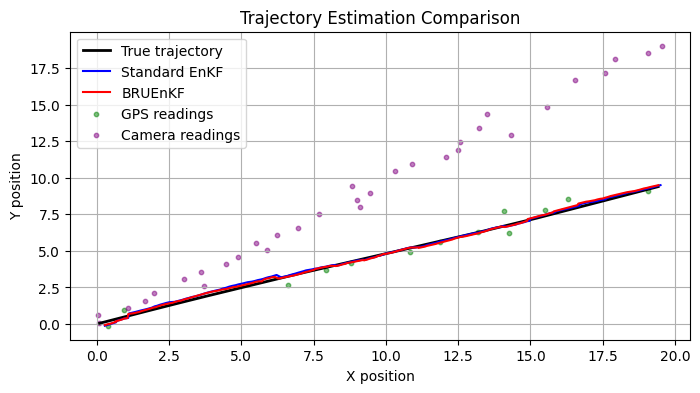

In [20]:
# Calculate position errors
pos_err_standard = np.sqrt((df["x_true"] - estimates_standard[:, 0])**2 +
                           (df["y_true"] - estimates_standard[:, 1])**2)

pos_err_bru = np.sqrt((df["x_true"] - estimates_bru[:, 0])**2 +
                      (df["y_true"] - estimates_bru[:, 1])**2)

# Calculate overall RMSE
rmse_standard = np.sqrt(np.mean(pos_err_standard**2))
rmse_bru = np.sqrt(np.mean(pos_err_bru**2))

print(f"Standard EnKF RMSE: {rmse_standard:.4f}")
print(f"BRUEnKF RMSE: {rmse_bru:.4f}")

# Plot trajectories
plt.figure(figsize=(8, 4))
plt.plot(df["x_true"], df["y_true"], 'k-', label="True trajectory", linewidth=2)
plt.plot(estimates_standard[:, 0], estimates_standard[:, 1], 'b-', label="Standard EnKF")
plt.plot(estimates_bru[:, 0], estimates_bru[:, 1], 'r-', label="BRUEnKF")

# Plot sensor readings
gps_mask = df[["gps_x", "gps_y"]].notna().all(axis=1)
plt.scatter(df.loc[gps_mask, "gps_x"], df.loc[gps_mask, "gps_y"],
            s=10, alpha=0.5, label="GPS readings", color='green')

cam_mask = df["cam_x"].notna()
plt.scatter(df.loc[cam_mask, "cam_x"], df.loc[cam_mask, "x_true"],
            s=10, alpha=0.5, label="Camera readings", color='purple')

plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Trajectory Estimation Comparison")
plt.legend()
plt.grid(True)
plt.show()





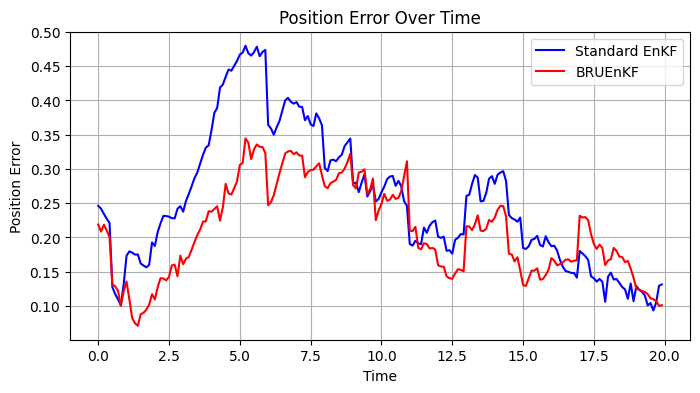

In [18]:
# Plot position errors over time
plt.figure(figsize=(8,4))
plt.plot(df["time"], pos_err_standard, 'b-', label="Standard EnKF")
plt.plot(df["time"], pos_err_bru, 'r-', label="BRUEnKF")
plt.xlabel("Time")
plt.ylabel("Position Error")
plt.title("Position Error Over Time")
plt.legend()
plt.grid(True)
plt.show()

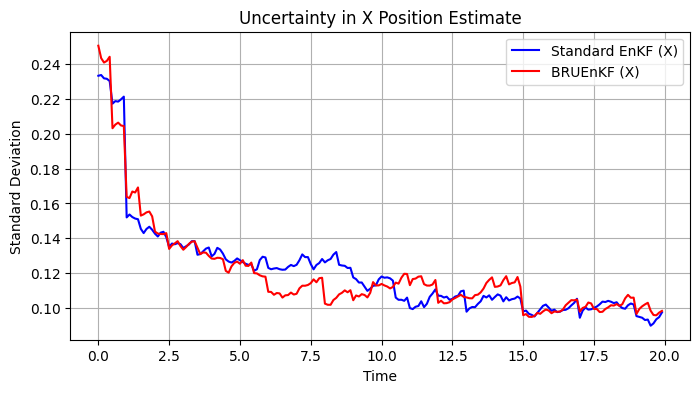

In [19]:
# Plot uncertainty estimates (standard deviations)
std_x_standard = np.sqrt(covariances_standard[:, 0, 0])
std_y_standard = np.sqrt(covariances_standard[:, 1, 1])
std_x_bru = np.sqrt(covariances_bru[:, 0, 0])
std_y_bru = np.sqrt(covariances_bru[:, 1, 1])

plt.figure(figsize=(8, 4))
plt.plot(df["time"], std_x_standard, 'b-', label="Standard EnKF (X)")
plt.plot(df["time"], std_x_bru, 'r-', label="BRUEnKF (X)")
plt.xlabel("Time")
plt.ylabel("Standard Deviation")
plt.title("Uncertainty in X Position Estimate")
plt.legend()
plt.grid(True)
plt.show()